### **CS 4372 Assignment 3 Sarvesh Gopalakrishnan (NET ID: sxg220257), Sreevasan Sivasubramanian (NET ID: sxs220434)**

### **Import Modules and Load Data**

In [77]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import os
import zipfile
import requests
from io import BytesIO
from tensorflow.keras.applications import MobileNetV2
import matplotlib.pyplot as plt
import time
import pandas as pd
import numpy as np
import random

In [7]:
# URL for Github repository ZIP
url = "https://github.com/Sarvesh30/CS4372-Project-3/archive/refs/heads/main.zip"

# Extract the data from the raw github link
response = requests.get(url)
with zipfile.ZipFile(BytesIO(response.content)) as zip_ref:
  zip_ref.extractall(".")

# Set paths to train/test directories
train_dir = "CS4372-Project-3-main/train"
test_dir = "CS4372-Project-3-main/test"

print("Train directory:", os.listdir(train_dir))
print("Test directory:", os.listdir(test_dir))

Train directory: ['american_football_train', 'baseball_train', 'basketball_train']
Test directory: ['american_football_test', 'baseball_test', 'basketball_test']


In [8]:
# Set up the training and testing data sets
img_size = (224, 224)
batch_size = 64

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels = 'inferred',
    label_mode = 'categorical',
    image_size = img_size,
    batch_size = batch_size,
    shuffle = True
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels = 'inferred',
    label_mode = 'categorical',
    image_size = img_size,
    batch_size = batch_size,
    shuffle = False
)

print("Class names", train_ds.class_names)

# Change the class names by removing _train and _test
train_ds.class_names = [name.replace("_train", "") for name in train_ds.class_names]
test_ds.class_names = [name.replace("_test", "") for name in test_ds.class_names]

Found 1124 files belonging to 3 classes.
Found 282 files belonging to 3 classes.
Class names ['american_football_train', 'baseball_train', 'basketball_train']


### **Model Building/Tuning/Evalutation (Configuration Set 1)**

In [10]:
# Create a training function to train different CNNs
def train_model(dense_units = 32, dropout_rate = 0.5, optimizer = 'adam', learning_rate = 1e-3, fine_tune = False, fine_tune_at = 100, epochs = 10):

  # Load in the pre-built MobileNetV2 model via transfer learning
  base_model = MobileNetV2(
    input_shape = (224, 224, 3),
    include_top = False,
    weights = "imagenet"
  )

  # Condition for possibly fine-tuning layers not in the base model
  if fine_tune:
    base_model.trainable = True
    for layer in base_model.layers[:fine_tune_at]:
      layer.trainable = False
  else:
    base_model.trainable = False

  # Build the model
  model = models.Sequential([
      base_model,
      layers.GlobalAveragePooling2D(),
      layers.Dense(dense_units, activation = 'relu'),
      layers.Dropout(dropout_rate),
      layers.Dense(3, activation = 'softmax')
  ])

  # Selecting the optimizer
  if optimizer == 'adam':
    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
  elif optimizer == 'sgd':
    optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate)
  elif optimizer == 'rmsprop':
    optimizer = tf.keras.optimizers.RMSprop(learning_rate = learning_rate)

  # Compiling the model
  model.compile(
      optimizer = optimizer,
      loss = 'categorical_crossentropy',
      metrics = ['accuracy']
  )

  # Implement early stopping to reduce overfitting
  early_stopping = tf.keras.callbacks.EarlyStopping(
      monitor = 'val_loss',
      patience = 5,
      restore_best_weights = True
  )

  # Training the model
  start = time.time()
  history = model.fit(
      train_ds,
      validation_data = test_ds,
      epochs = epochs,
      callbacks = [early_stopping],
      verbose = 1
  )
  end = time.time()

  # Tracking performance metrics (training/testing accuracy) & (training/testing loss)
  train_acc = history.history['accuracy']
  test_acc = history.history['val_accuracy']
  train_loss = history.history['loss']
  test_loss = history.history['val_loss']

  return model, history, train_acc, test_acc, train_loss, test_loss, end - start

In [ ]:
# Determine various parameter/tuning combinations

# --> Config_set1 focuses on testing different tuning combinations in terms of the dense_units, 
#     dropout_rate, optimizer, learning_rate, whether to freeze layers, and the number of layers to unfreeze
# --> The epochs are set to a small number for experimentation and will be increased with config_set2
config_set1 = [
    {'dense_units': 64, 'dropout_rate': 0.5, 'optimizer': 'adam', 'learning_rate': 1e-3,'fine_tune': False, 'fine_tune_at': 140, 'epochs': 10},
    {'dense_units': 128, 'dropout_rate': 0.5, 'optimizer': 'adam', 'learning_rate': 1e-4, 'fine_tune': True, 'fine_tune_at': 145, 'epochs': 10},
    {'dense_units': 64, 'dropout_rate': 0.5, 'optimizer': 'sgd', 'learning_rate': 1e-3, 'fine_tune': False, 'fine_tune_at': 150, 'epochs': 10},
    {'dense_units': 128, 'dropout_rate': 0.5, 'optimizer': 'sgd', 'learning_rate': 1e-4, 'fine_tune': True, 'fine_tune_at': 153, 'epochs': 10},
    {'dense_units': 32, 'dropout_rate': 0.1, 'optimizer': 'rmsprop', 'learning_rate': 1e-2,'fine_tune': True, 'fine_tune_at': 150, 'epochs': 10}
]

In [ ]:
# Train/test the models for config_set1
results = []
performance = []
model_list = []

# Loop through all of the configurations in config_set1
for i, cfg in enumerate(config_set1):
  # Call the train_model function for every configuration
  print(f"Training model {i+1}")
  model, history, train_acc, test_acc, train_loss, test_loss, elapsed_time = train_model(**cfg)
  # Append the history for each model to the performance list
  performance.append(history)

  # Append the results for each model configuration
  results.append({
      'Iteration' : i + 1,
      'Dense Units': cfg['dense_units'],
      'Dropout Rate': cfg['dropout_rate'],
      'Optimizer': cfg['optimizer'],
      'Learning Rate': cfg.get('learning_rate', 0.001),
      'Fine-Tune': cfg['fine_tune'],
      'Fine-Tune At': cfg['fine_tune_at'],
      'Epochs': cfg['epochs'],
      'Training Accuracy': round(train_acc[-1], 3),
      'Testing Accuracy': round(test_acc[-1], 3),
      'Train Time (s)' : round(elapsed_time, 3)
  })

# Store the results as a pandas data frame and show results
result_c1_df = pd.DataFrame(results)
print(result_c1_df)

Training model 1
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.4096 - loss: 1.2664 - val_accuracy: 0.7092 - val_loss: 0.8055
Epoch 2/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 18s 996ms/step - accuracy: 0.6242 - loss: 0.8305 - val_accuracy: 0.7163 - val_loss: 0.6674
Epoch 3/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 17s 968ms/step - accuracy: 0.6682 - loss: 0.7255 - val_accuracy: 0.7092 - val_loss: 0.6312
Epoch 4/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 17s 951ms/step - accuracy: 0.6995 - loss: 0.6512 - val_accuracy: 0.7447 - val_loss: 0.5906
Epoch 5/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 17s 966ms/step - accuracy: 0.7435 - loss: 0.5969 - val_accuracy: 0.7624 - val_loss: 0.5629
Epoch 6/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 18s 997ms/step - accuracy: 0.7865 - loss: 0.5223 - val_accuracy: 0.7695 - val_loss: 0.5391
Epoch 7/10
18/18 ━━━━━━━━━━━━━━━━━━━━ 18s 999ms/step - accuracy: 0.7831 - loss: 0.5353 - val_accuracy: 0.7730 - val_loss: 0.5221
Epoch 8/10
18/18 ━━━━━━━━━━━━━━━━━

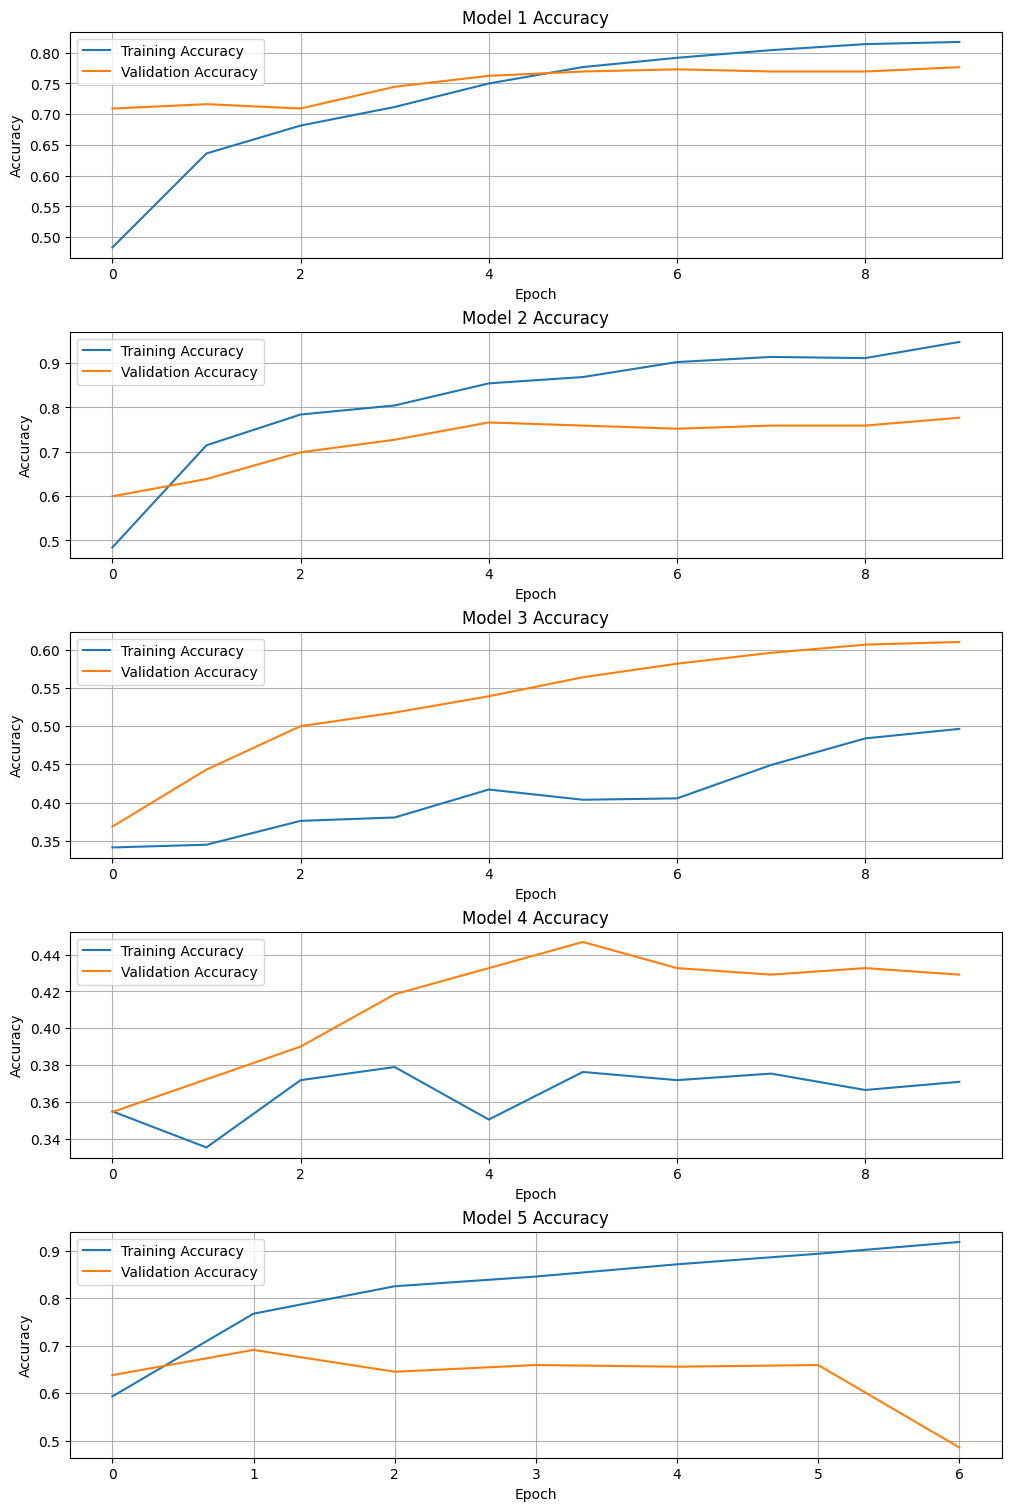

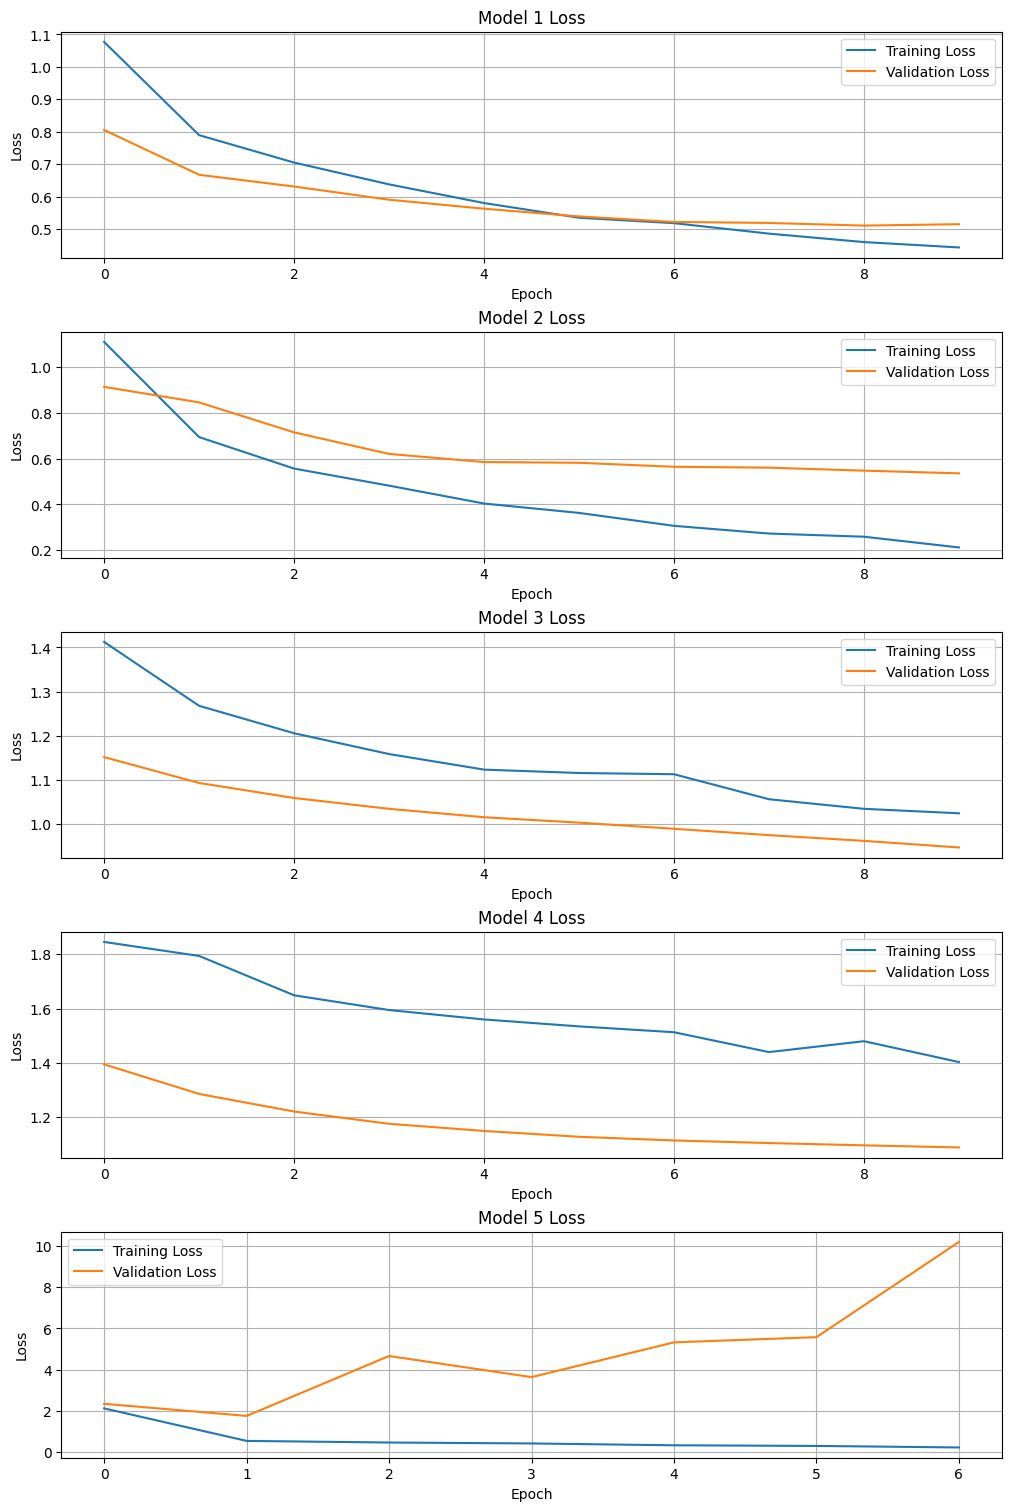

In [ ]:
# Plot the training/testing accuracy for each model in config_set1
model_count = len(performance)
fig, axes = plt.subplots(model_count, 1, figsize=(10, model_count * 3), constrained_layout = True)
for i, hist in enumerate(performance):
  axes[i].plot(hist.history['accuracy'], label = 'Training Accuracy')
  axes[i].plot(hist.history['val_accuracy'], label = 'Validation Accuracy')
  axes[i].set_title(f'Model {i + 1} Accuracy')
  axes[i].set_xlabel('Epoch')
  axes[i].set_ylabel('Accuracy')
  axes[i].legend()
  axes[i].grid(True)
plt.show()

# Plot the training/testing losses for each model in config_set1
model_count = len(performance)
fig, axes = plt.subplots(model_count, 1, figsize=(10, model_count * 3), constrained_layout = True)
for i, hist in enumerate(performance):
  axes[i].plot(hist.history['loss'], label = 'Training Loss')
  axes[i].plot(hist.history['val_loss'], label = 'Validation Loss')
  axes[i].set_title(f'Model {i + 1} Loss')
  axes[i].set_xlabel('Epoch')
  axes[i].set_ylabel('Loss')
  axes[i].legend()
  axes[i].grid(True)
plt.show()

# From the subplots, we can observe that model 1 and model 2 have the best performance out of the 5 initial
#   models that were trained. This is because both models have the best validation accuracy and the gap between
#   the training and validation accuracy is the smallest as the number of epochs are increased. 

# Model 1 and Model 2 utilized the adam optimizer compared to models 3 and 5 which could result in improved 
#   performance. Model 2 had a better training accuracy which may have occured due to top layers of MobileNetV2 being unfrozen
#   in Model 2 compared to Model 1 where no layers from the MobileNetV2 model were frozen. 

### **Model Building/Tuning/Evalutation (Configuration Set 2)**

In [21]:
# Config_set1 showed that the initial models perform well with the adam optimizer. Additionally, model 2 performed very well on
#   the training set. To reduce chances of overfitting, the dropout rate could be changed in model 2's configuration. Below,
#   we have configured a new set of tuning combinations with a larger number of epochs to improve performance. 
config_set2 = [
    {'dense_units': 64, 'dropout_rate': 0.5, 'optimizer': 'adam', 'learning_rate': 1e-3,'fine_tune': False, 'fine_tune_at': 140, 'epochs': 30},
    {'dense_units': 128, 'dropout_rate': 0.8, 'optimizer': 'adam', 'learning_rate': 1e-3, 'fine_tune': True, 'fine_tune_at': 145, 'epochs': 30}
]

In [22]:
# Train/test the models for config_set2
results_new = []
performance_new = []
model_list = []

# Loop through all of the configurations in config_set2
for i, cfg in enumerate(config_set2):
  # Call the train_model function for every configuration
  print(f"Training model {i+1}")
  model, history, train_acc, test_acc, train_loss, test_loss, elapsed_time = train_model(**cfg)
  # Append the history for each model to the performance list
  performance_new.append(history)
  # Append the model to the model list
  model_list.append(model)

  # Append the results for each model configuration
  results_new.append({
      'Iteration' : i + 1,
      'Dense Units': cfg['dense_units'],
      'Dropout Rate': cfg['dropout_rate'],
      'Optimizer': cfg['optimizer'],
      'Learning Rate': cfg.get('learning_rate', 0.001),
      'Fine-Tune': cfg['fine_tune'],
      'Fine-Tune At': cfg['fine_tune_at'],
      'Epochs': cfg['epochs'],
      'Training Accuracy': round(train_acc[-1], 3),
      'Testing Accuracy': round(test_acc[-1], 3),
      'Train Time (s)' : round(elapsed_time, 3)
  })

# Store the results as a pandas data frame and show results
result_c2_df = pd.DataFrame(results_new)
print(result_c2_df)

Training model 1
Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 22s 992ms/step - accuracy: 0.4477 - loss: 1.2042 - val_accuracy: 0.6773 - val_loss: 0.7553
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 17s 925ms/step - accuracy: 0.6265 - loss: 0.8037 - val_accuracy: 0.7376 - val_loss: 0.6465
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 17s 925ms/step - accuracy: 0.7084 - loss: 0.6869 - val_accuracy: 0.7518 - val_loss: 0.6061
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 16s 917ms/step - accuracy: 0.7312 - loss: 0.6226 - val_accuracy: 0.7624 - val_loss: 0.5592
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 17s 959ms/step - accuracy: 0.7607 - loss: 0.5759 - val_accuracy: 0.7801 - val_loss: 0.5581
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 18s 993ms/step - accuracy: 0.7676 - loss: 0.5516 - val_accuracy: 0.7730 - val_loss: 0.5551
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 17s 934ms/step - accuracy: 0.7834 - loss: 0.5163 - val_accuracy: 0.7837 - val_loss: 0.5379
Epoch 8/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 17s 923ms/step - accuracy: 0.8241 - loss: 

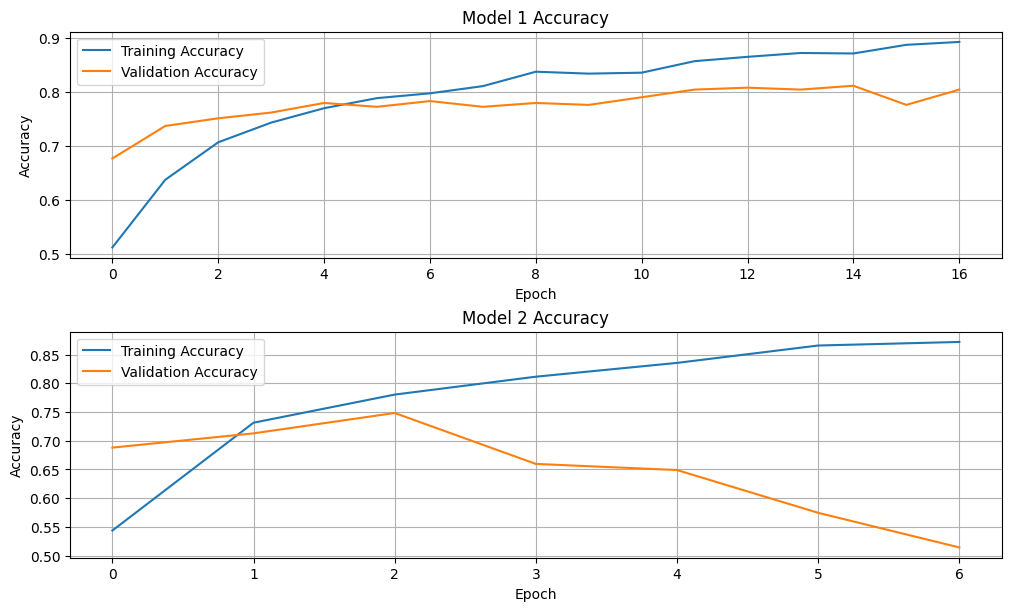

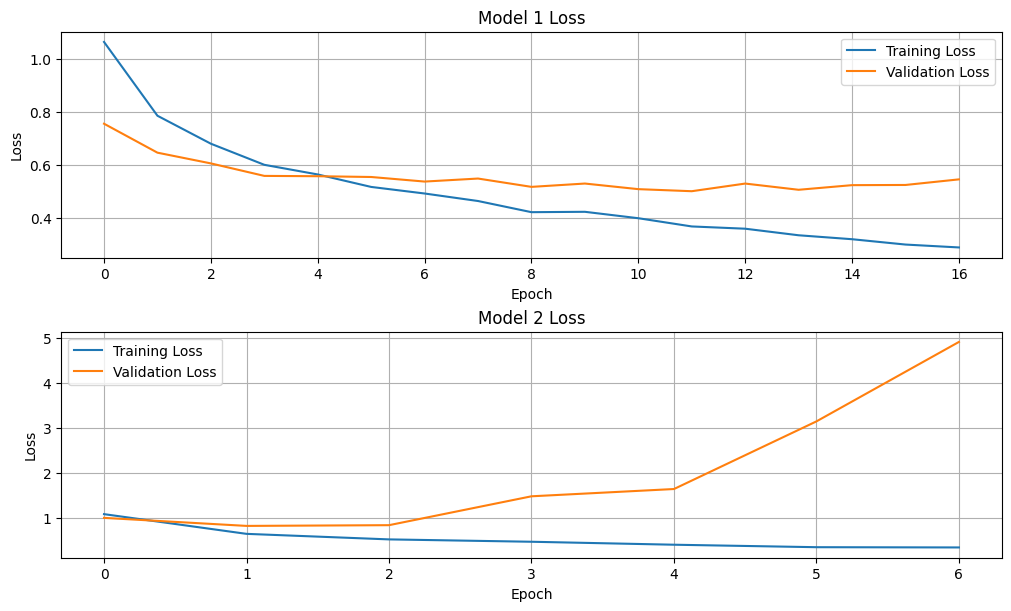

In [35]:
# Plot the training/testing accuracy for each model in config_set2
model_count = len(performance_new)
fig, axes = plt.subplots(model_count, 1, figsize=(10, model_count * 3), constrained_layout = True)
for i, hist in enumerate(performance_new):
  axes[i].plot(hist.history['accuracy'], label = 'Training Accuracy')
  axes[i].plot(hist.history['val_accuracy'], label = 'Validation Accuracy')
  axes[i].set_title(f'Model {i + 1} Accuracy')
  axes[i].set_xlabel('Epoch')
  axes[i].set_ylabel('Accuracy')
  axes[i].legend()
  axes[i].grid(True)
plt.show()

# Plot the training/testing losses for each model in config_set2
model_count = len(performance_new)
fig, axes = plt.subplots(model_count, 1, figsize=(10, model_count * 3), constrained_layout = True)
for i, hist in enumerate(performance_new):
  axes[i].plot(hist.history['loss'], label = 'Training Loss')
  axes[i].plot(hist.history['val_loss'], label = 'Validation Loss')
  axes[i].set_title(f'Model {i + 1} Loss')
  axes[i].set_xlabel('Epoch')
  axes[i].set_ylabel('Loss')
  axes[i].legend()
  axes[i].grid(True)
plt.show()

# Model 1 achieves better performance in terms of validation accuracy. Increasing the dropout rate and
#   the learning rate for Model 2 significantly hurt Model 2's validation accuracy as it only achieves
#   0.514 validation accuracy compared to 0.77 validation accuracy before the changes. This may have 
#   occurred due to tuning of the top layers being extremely sensitive to the dropout rate. We will
#   use Model 1 to show the 25 examples of testing points as it achieved the best performance. 

# Concatenate results from both data frames
result_final = pd.concat([result_c1_df, result_c2_df], ignore_index = True)

In [45]:
# Fix the iteration column for result_final
result_final['Iteration'] = range(1, len(result_final) + 1)
print(result_final)

   Iteration  Dense Units  Dropout Rate Optimizer  Learning Rate  Fine-Tune  \
0          1           64           0.5      adam         0.0010      False   
1          2          128           0.5      adam         0.0001       True   
2          3           64           0.5       sgd         0.0010      False   
3          4          128           0.5       sgd         0.0001       True   
4          5           32           0.1   rmsprop         0.0100       True   
5          6           64           0.5      adam         0.0010      False   
6          7          128           0.8      adam         0.0010       True   

   Fine-Tune At  Epochs  Training Accuracy  Testing Accuracy  Train Time (s)  
0           140      10              0.818             0.777         183.900  
1           145      10              0.948             0.777         204.187  
2           150      10              0.496             0.610         180.252  
3           153      10              0.371         

### **Visualizing 25 Test Points with Best Model**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


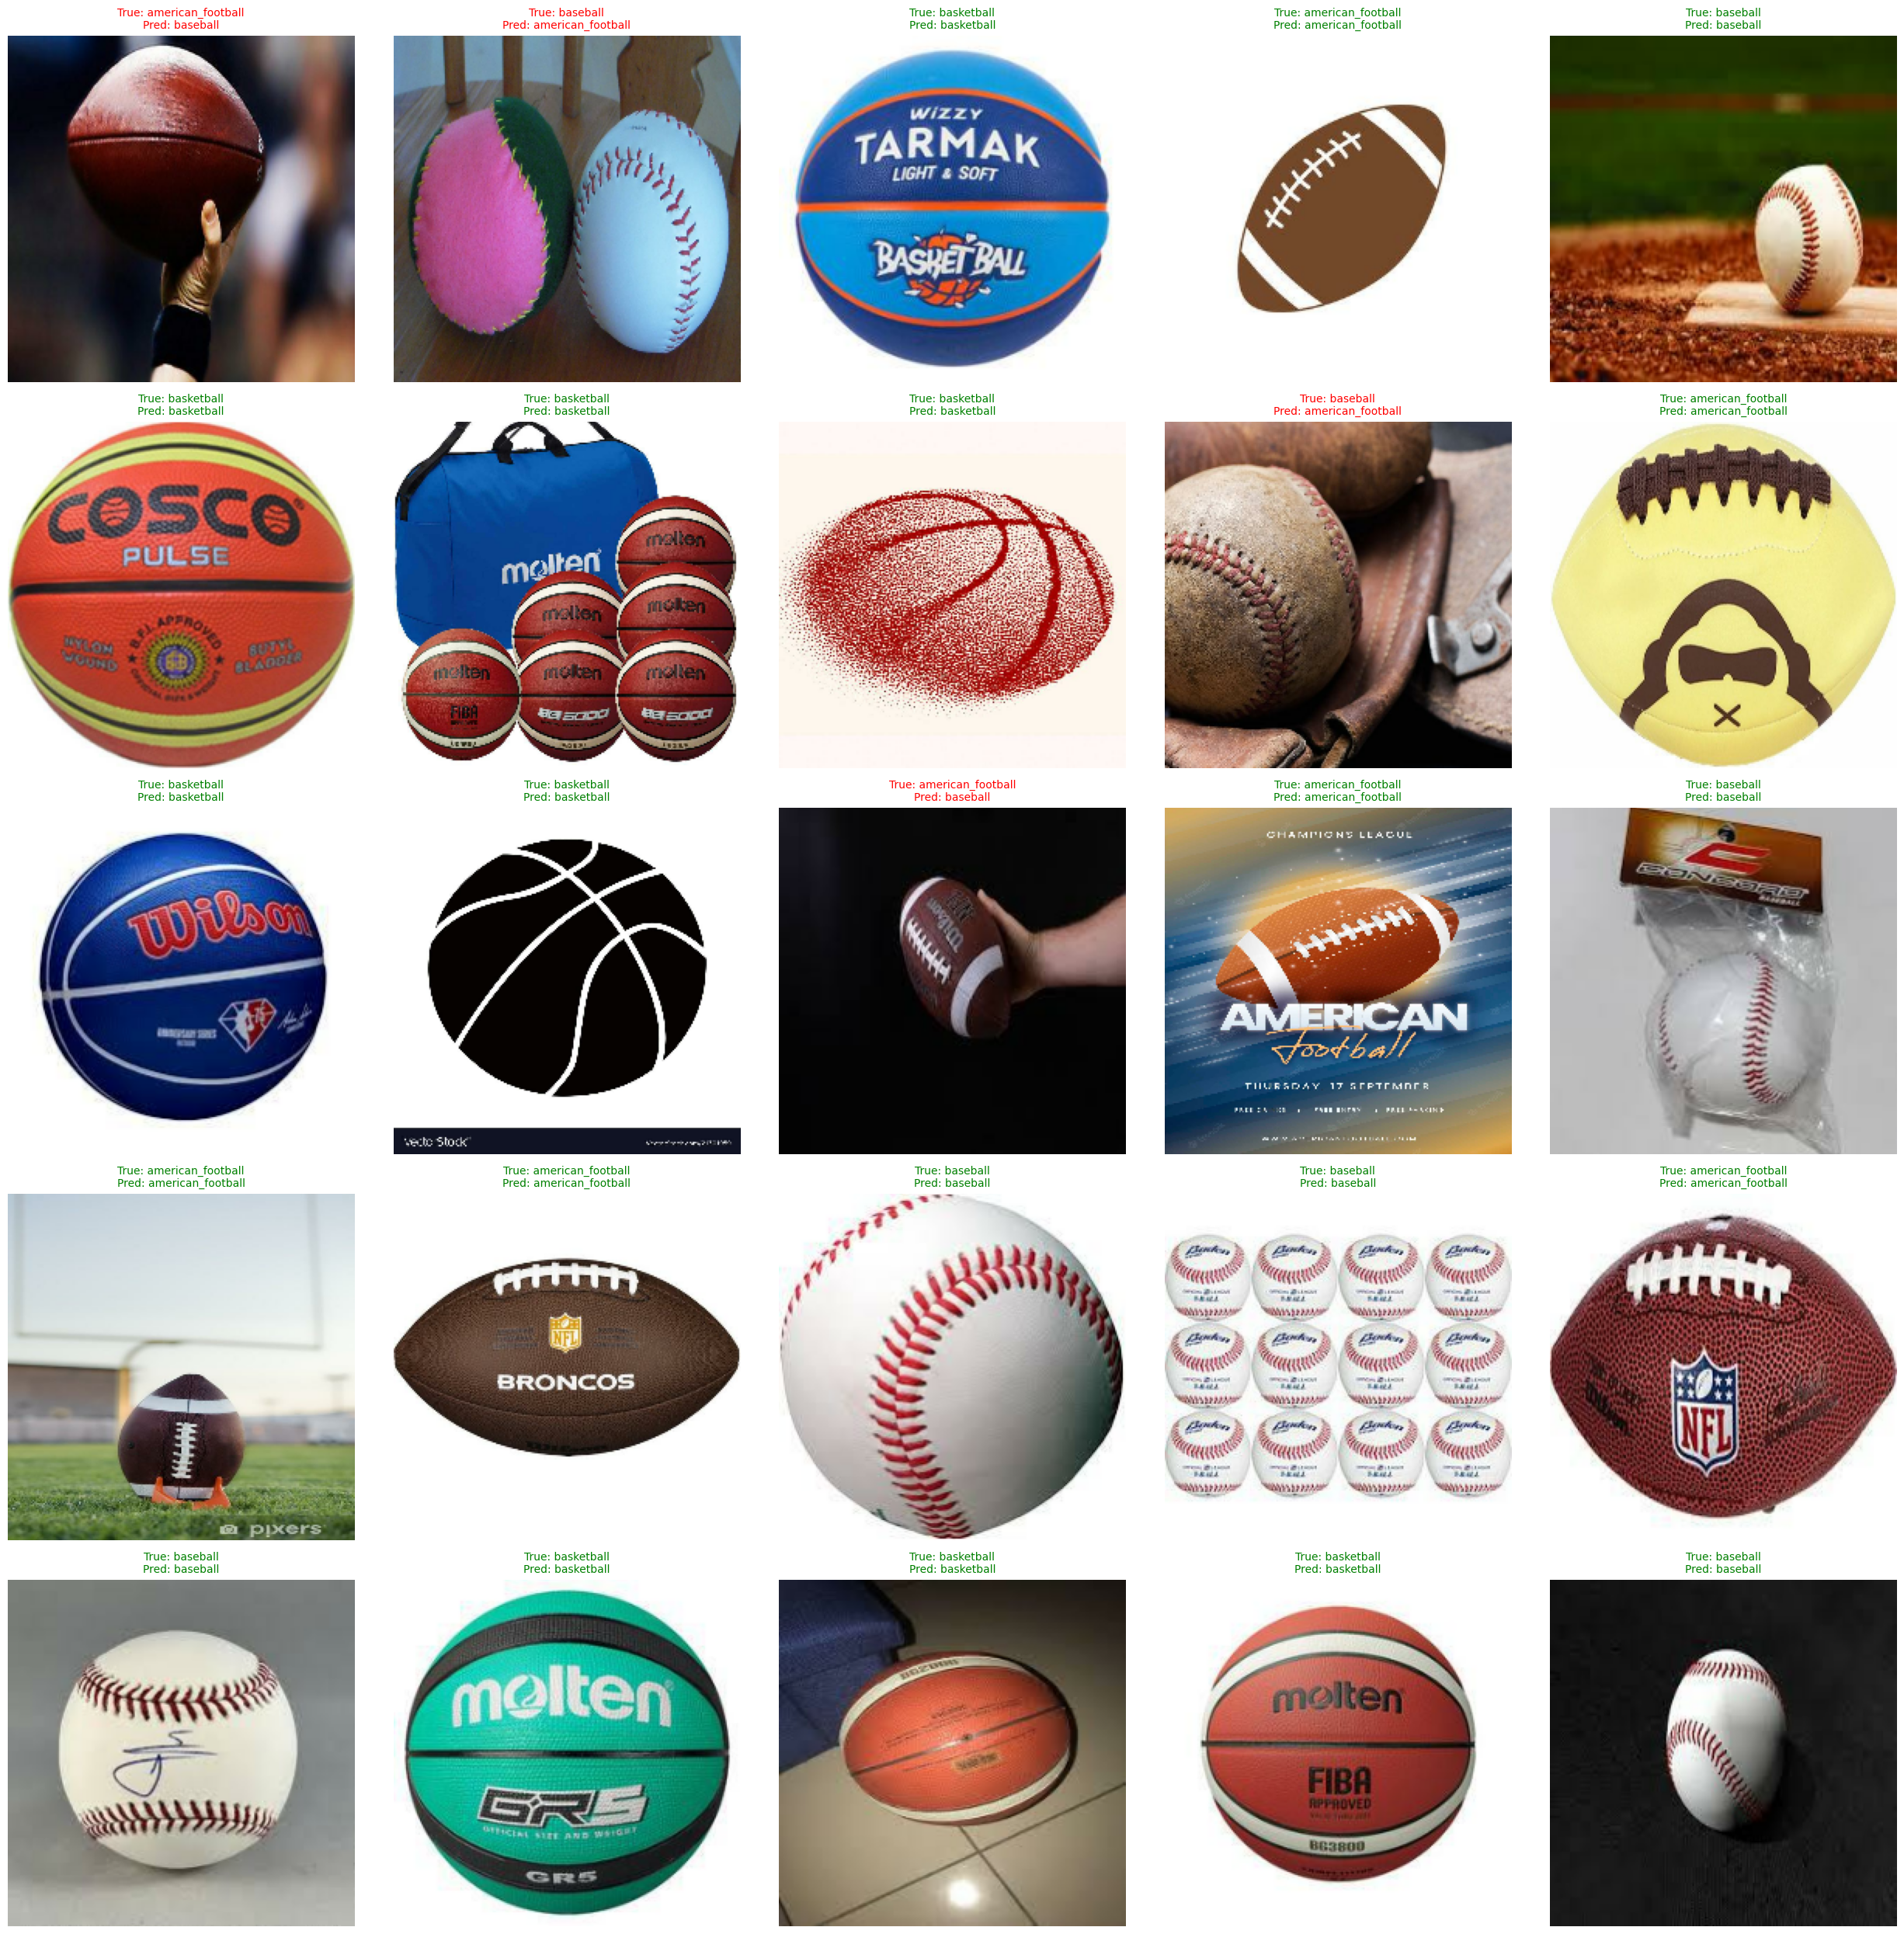

In [85]:
# Pull the best model from config set 2
best_model = model_list[0]

# Pulll a random sample of 25 points from test dataset
class_names = ['american_football', 'baseball', 'basketball']
all_images = []
all_labels = []
for images_batch, labels_batch in test_ds:
    all_images.extend(images_batch.numpy())
    all_labels.extend(labels_batch.numpy())

all_labels = np.array(all_labels)
all_images = np.array(all_images)

random.seed(10)
batch_idx = random.sample(range(len(all_images)), 25)

test_images = all_images[batch_idx]
test_labels = all_labels[batch_idx]

# Predict the labels with best_model
pred_probs = best_model.predict(test_images)
pred_labels = np.argmax(pred_probs, axis = 1)
true_labels = np.argmax(test_labels, axis = 1)

# Plot the 25 testing examples
plt.figure(figsize = (25, 25))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(test_images[i].astype("uint8"))
    plt.axis("off")
    true_label = class_names[true_labels[i]]
    pred_label = class_names[pred_labels[i]]
    color = "green" if true_label == pred_label else "red"
    plt.title(f"True: {true_label}\nPred: {pred_label}", color = color, fontsize = 10)
plt.tight_layout()
plt.show()